In [50]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import doctest # To test the code with the examples in the docstring of the functions
import os
from PIL import Image

# II.B. Eigenface Method

In [46]:
def averageFace(Q : np.array) -> np.array :
    """
    Compute the average face of a set of images (sketches or photos)

    Parameters
    ----------
    Q : np.array
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.
        
    Returns
    -------
    np.array
        A 2D numpy array of shape (n, 1) containing the average face.
    """
    return np.mean(Q, axis=1).reshape(-1,1)

def eigenfaces(Q : np.array) -> np.array :
    """ 
    Implementation of the eigenfaces algorithm

    Parameters
    ----------
    Q : np.array
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images
    
    Returns
    -------
    np.array
        A 2D numpy array of shape (n, m) containing the eigenfaces
    np.array
        A 2D numpy array of shape (n, m) containing the eigenvectors
    np.array
        A 2D numpy array of shape (m, m) containing the matrix of eigenvalues after transformations

    >>> eigenfaces(np.array([[2,0],[0,5]]))[0].shape
    (2, 2)

    """
    # Compute the mean of the columns of Q (mean image)
    mp = averageFace(Q)
    # Subtract the mean from each column of Q
    Ap = Q - mp
    # Compute eigenvector matrix and eigenvalues of Atp*Ap
    eigvals, Vp = np.linalg.eig(np.matmul(Ap.transpose(),Ap))



    # # Remove the negative eigenvalues for the sqrt
    # Vp = np.delete(Vp, eigvals < 0, axis=1)
    # eigvals = np.delete(eigvals, eigvals < 0)
    

    
    # Compute the orthormal eigenvector matrix of the covariance matrix
    eigPower = np.linalg.inv(sp.linalg.sqrtm(np.diag(eigvals)))
    Up = np.matmul(np.matmul(Ap,Vp),eigPower)

    return Up, Vp, eigPower

def featuresEigenfaces(Up : np.array, P : np.array) -> np.array :
    """
    Implementation of the featuresEigenfaces algorithm.

    Parameters
    ----------
    Up : np.array
        A 2D numpy array of shape (n, m) containing the eigenfaces.
    P : np.array
        A 2D numpy array of shape (n, k) where n is the number of pixels in each image and k is the number of images.

    Returns
    -------
    np.array
        A 2D numpy array of shape (m, k) containing the features of the images.
    """
    return np.matmul(Up.transpose(),P)

In [25]:
# use doctest to test the functions
doctest.testmod(verbose=True)

Trying:
    eigenfaces(np.array([[2,0],[0,5]]))[0].shape
Expecting:
    (2, 2)
ok
4 items had no tests:
    __main__
    __main__.averageFace
    __main__.featuresEigenfaces
    __main__.getData
1 items passed all tests:
   1 tests in __main__.eigenfaces
1 tests in 5 items.
1 passed and 0 failed.
Test passed.


TestResults(failed=0, attempted=1)

In [65]:
def getData(path : str) -> np.array:
    """
    Reads the images data in the given path and returns it as a numpy array (each column represent an image)

    Parameters
    ----------
    path : str
        The path to the directory containing the images data.

    Returns
    -------
    np.array
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.
    list
        A list containing the filenames of the images.
    """
    # Initialize the array of images
    dir = os.listdir(path)
    img = Image.open(path + dir[0])
    # if image has 3 channels, convert it to grayscale
    img = img.convert('L') if len(np.array(img).shape) == 3 else img

    nbPixels = np.array(img).flatten().shape

    images = np.empty((nbPixels[0],len(dir)))

    filenames = []
    for i,filename in enumerate(dir):
        img = Image.open(path + filename)
        # if image has 3 channels, convert it to grayscale
        img = img.convert('L') if len(np.array(img).shape) == 3 else img
        images[:,i] = np.array(img).flatten().transpose()

        filenames.append(filename)

    return images, filenames

def plotResults(inputRGB : np.array,inputGrayscale : np.array, pseudoSketch : np.array, imageName : str, sketchPath : str):
    """ 
    Create a plot of three subplots to show the results

    Parameters
    ----------
    inputRGB : np.array
        A 3D numpy array of shape (n, m, 3) containing the input RGB image.
    inputGrayscale : np.array
        A 2D numpy array of shape (n*m) containing the input grayscale image.
    pseudoSketch : np.array
        A 2D numpy array of shape (n*m) containing the pseudo-sketch image.

    Returns
    -------
    None
    """
    size = inputRGB.shape[0:2]

    fig, ax = plt.subplots(2,2)
    ax[0,0].imshow(inputRGB)
    ax[0,0].set_title('Original Image')
    ax[0,0].axis('off')
    ax[0,1].imshow(inputGrayscale.reshape(size),cmap='gray')
    ax[0,1].set_title('Grayscale Image')
    ax[0,1].axis('off')
    ax[1,0].imshow(pseudoSketch.reshape(size),cmap='gray')
    ax[1,0].set_title('Pseudo-sketch Image')
    ax[1,0].axis('off')

    ax[1,1].imshow(np.array(Image.open(sketchPath + imageName[:-4] + "-sz1.jpg")),cmap='gray')
    ax[1,1].set_title('Real sketch Image')
    ax[1,1].axis('off')



    plt.show()

In [14]:
images = getData("./data/photos/")

eigenfacesMatrix, _, _ = eigenfaces(images)
    
features = featuresEigenfaces(eigenfacesMatrix, images)

# III.A. Photo-to-Sketch Transformation

> In this section, we reimplement the III.A part of the article, following the 6 steps described

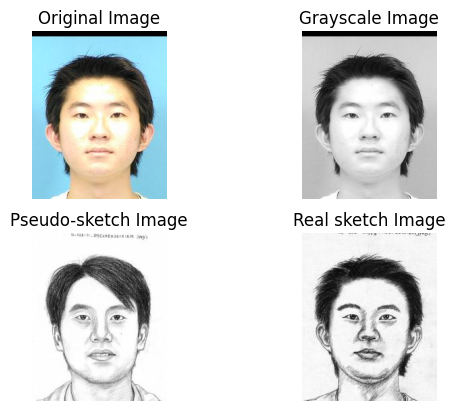

In [66]:
photoPath = "./data/photos/"
sketchPath = "./data/sketches/"

# Get the data then split into training and testing sets for the photos
photoSet, photoNames = getData(photoPath)
sketchSet, SketchNames = getData(sketchPath)

delimTrain = int(photoSet.shape[1]*0.8) # 80% of the data for training

trainingSet = photoSet[:,:delimTrain]
testingSet = photoSet[:,delimTrain:]

# Get the input image and its name
numImage = delimTrain + 1

inputImage = testingSet[:,1].reshape(-1,1)
imageName = photoNames[numImage]
inputRGB = np.array(Image.open(photoPath + imageName))

# Step 1
mp = averageFace(photoSet)
ms = averageFace(sketchSet)

# Step 2
Up, Vp, eigPower = eigenfaces(photoSet)

# Step 3
Pk = inputImage - mp

# Step 4
bp = featuresEigenfaces(Up, Pk)

# Step 5 : Reconstruction of the pseudo-sketch
As = sketchSet - ms
Sr = np.matmul(np.matmul(np.dot(As,Vp), eigPower),bp)

# Step 6 :
Tr = Sr + ms

# Get the real part of the image and plot the results
pseudoSketch = Tr.real
plotResults(inputRGB, inputImage, pseudoSketch,imageName, sketchPath)

In [58]:
imageName

'm1-004-01.jpg'